In [20]:
using Pkg
Pkg.activate("../IVTmodel")
Pkg.instantiate()
include("../modules/IVTmodel.jl")
#Generates settings for parameters used
fittingmodel = setupmodel_IVT4()
#Imports calibration data from csv files
modeldata = importakamadata()
osumidata = importosumidata()
#Imports PPiase validation data
PPiasedata = importakamaPPiasedata();
akamafittedparametersmatrix = Matrix(CSV.read("../outputs/fittedparameters.csv", DataFrame,header=false))
fittedparamslist = reshape(akamafittedparametersmatrix,(size(akamafittedparametersmatrix)[1],))
covariancemat = Matrix(CSV.read("../outputs/covariancematrix.csv", DataFrame,header=false))
fittedparams = fullparameterset(fittingmodel,fittedparamslist)
printresidual(fittingmodel,modeldata,osumidata,fittedparamslist)

  Activating project at `C:\Users\ChemeGrad2021\Documents\Braatz Group\MRNA Synthesis\Published code\IVT2.0\IVTmodel`
Precompiling project...
  ? Metrics


Model has 25 fitted parameters, 17 of which have a bayesian prior
Total Residual:                        1007.3
Components of residual:
Concentration Trajectories (Figure 2): 418.6
Initial Reaction Rate (Figure 3A):     135.2
Mg2PPi solubility (Figure 3B):         216.4
Parameter priors:                      159.5
pH Effect Data:                        77.6


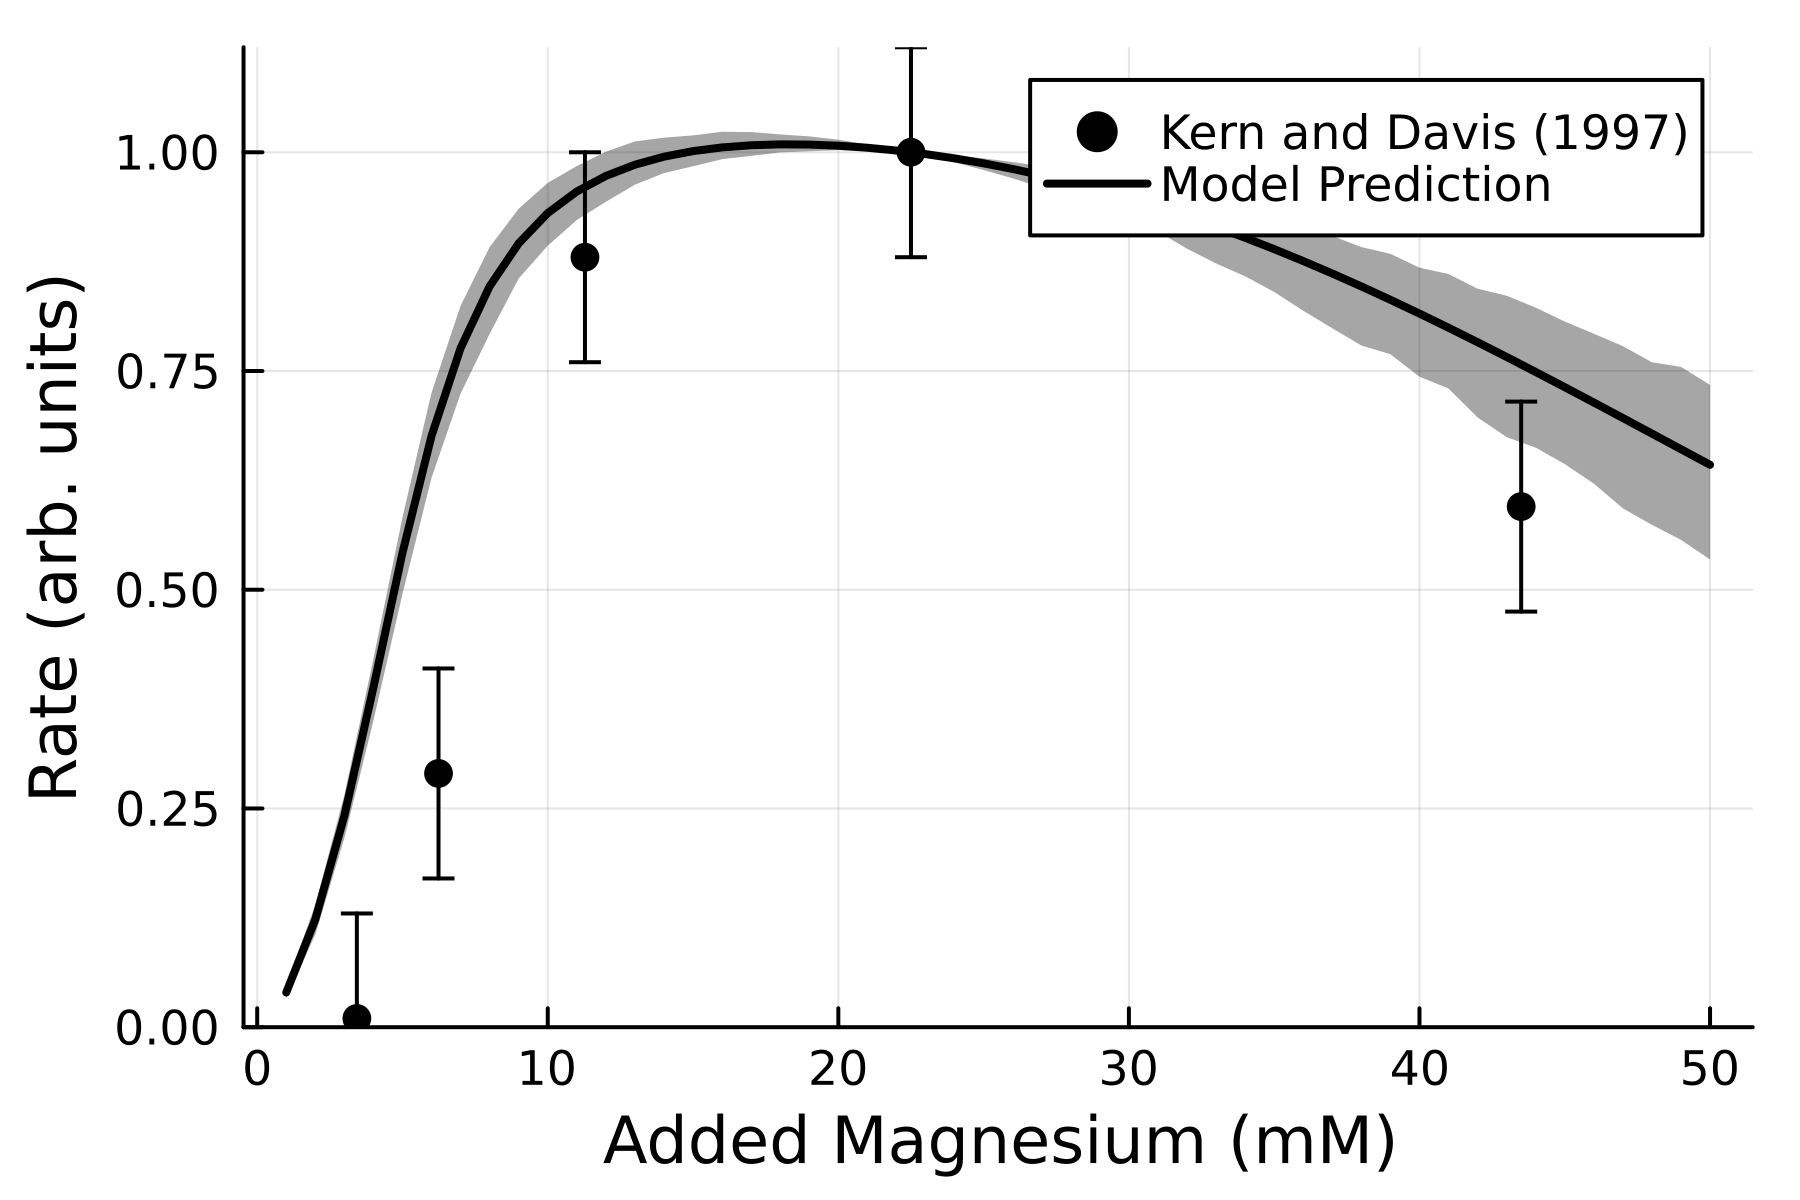

In [21]:
function getKernIS(param,anionconcentration;Clused = true)#Takes anion (Cl or OAc) concentration in mM
        NTPtot = 10.6e-3
        Mgtot = 20e-3
        aniontot = 40e-3+anionconcentration/1000
        Buffertot = 0.04
        Natot = 1e-8+Buffertot*((10^(-0.45))/(10^(-0.45)+1))+anionconcentration/1000
        PPitot = 1e-8
        Pitot = 1e-8
        if Clused
            Cltot = aniontot
        end
        (H, Mg, Na) = getfreeconcentrations(param, NTPtot, Mgtot, Buffertot, PPitot, Pitot, Natot, Cltot;buffer_pka = 7.48)
        return 1e3*speciationmodel(param, 0, NTPtot, Mgtot, Buffertot, PPitot, Pitot, Natot, H, Mg, Na, Cltot)[1][6]
        #return getfreeconcentrations(param, NTPtot, Mgtot, Buffertot, PPitot, Pitot, Natot, Cltot;buffer_pka = 7.48)
end

function getKernrate(param,anionconcentration;OAccounterion = false)#Takes anion (Cl or OAc) concentration in mM
        UTPtot = 4e-3
        GTPtot = 4e-3
        CTPtot = 2.6e-3
        Mgtot = 20e-3
        Buffertot = 0.04

        T7 = 0.12e-6
        DNA = 90
        PPiase = 1.0
        stoich = (0,1.65,3.25,5)
        inputs =(T7RNAP = T7, ATP = 1e-9,UTP = UTPtot,CTP = CTPtot,GTP = GTPtot, Mg = Mgtot, Buffer = Buffertot, DNA = DNA, final_time = 1.0)
        sol = runDAE_batch(param,inputs, PPiase = 1.0, stoich = (0,1.65,3.25,5), OAccounterion = OAccounterion, Naanion = anionconcentration/1000, seperateDNA = true)
        return totalrna(sol,0)[end]
end

function getKernrateMg(param,MgOAcconcentration)#Takes anion (Cl or OAc) concentration in mM
        UTPtot = 2e-3
        GTPtot = 2e-3
        CTPtot = 1.3e-3
        Buffertot = 0.04

        T7 = 0.08e-6
        DNA = 60
        PPiase = 1.0
        stoich = (0,1.65,3.25,5)
        inputs =(T7RNAP = T7, ATP = 1e-9,UTP = UTPtot,CTP = CTPtot,GTP = GTPtot, Mg = MgOAcconcentration/1000, Buffer = Buffertot, DNA = DNA, final_time = 1.0)
        sol = runDAE_batch(param,inputs, PPiase = 1.0, stoich = (0,1.65,3.25,5), OAccounterion = true, Naanion = (110-2*MgOAcconcentration)/1000, seperateDNA = true)
        return totalrna(sol,0)[end]
end
Mgplottingnmc = 1000
kernMgrange = LinRange(1,50,50)

relativefreeMgrate(fittedparams,Mgconc) = getKernrateMg(fittedparams,Mgconc)/getKernrateMg(fittedparams,22.5)

predictedkernrateMg = [relativefreeMgrate(fittedparams,Mgconc) for Mgconc in kernMgrange]
Mgrate_CB = hcat([mcbounds(fittingmodel,fittedparamslist,covariancemat,p -> relativefreeMgrate(p,Mgconc),nmc = Mgplottingnmc) for Mgconc in kernMgrange]...)

# kernIS = [getKernIS(fittedparams,anion) for anion in kernanion]
# kernISprediction = [empiricalISeffect(IS/1000) for IS in ISrange]
kernMg = [3.43,6.24,11.28,22.5,43.5]
kernrateMg = [0.01,0.29,0.88,1.0,0.595]
#kernrateOAc = [0.43,0.42,0.31,0.15] * 500

plt = scatter(kernMg,kernrateMg, label = "Kern and Davis (1997)", color = :black,yerror = 0.12)
#scatter!(kernanion,kernrateOAc)

plot!(kernMgrange,predictedkernrateMg,size = (450,300), xlabel = "Added Magnesium (mM)", ylabel = "Rate (arb. units)", color = :black, label = "Model Prediction", linewidth = 2)
plot!(kernMgrange, Mgrate_CB[1,:], fillrange = Mgrate_CB[2,:], fillalpha = 0.35,alpha=0.0, color = :black,linewidth = 0.0,label="")

plot!(dpi = 400,ylims = (0,Inf))
savefig(plt,"../figures/GM6_27/freeMgeffect.png")
plt

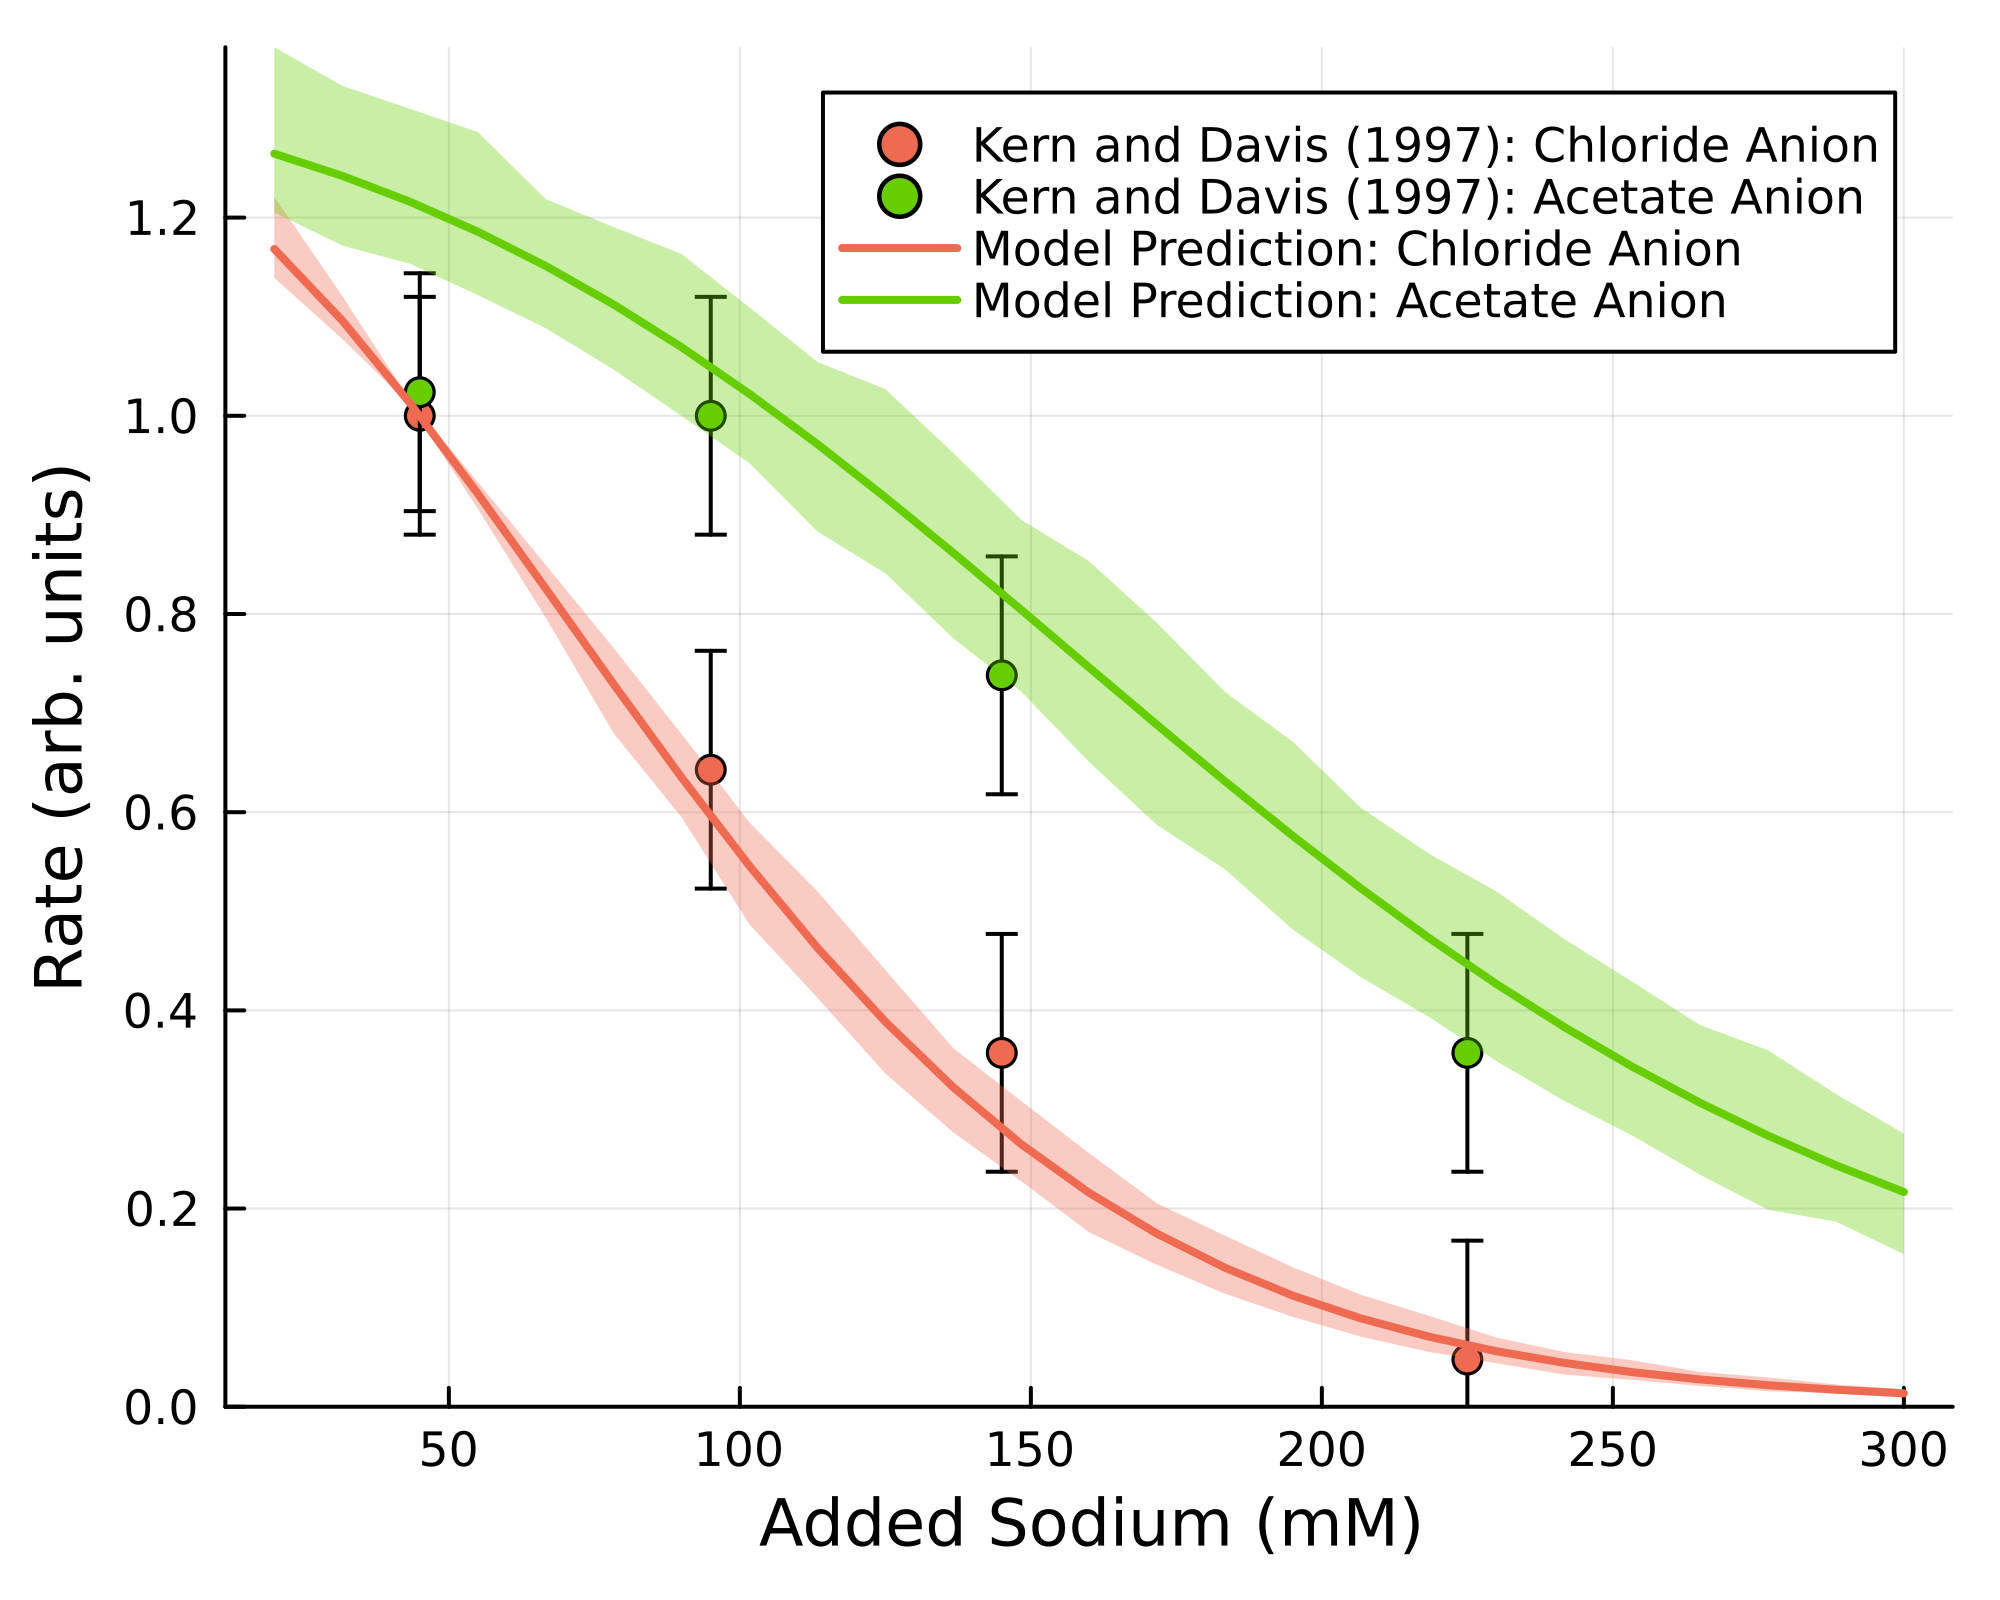

In [22]:
relativecounterionrate(fittedparams,anionconc;OAccounterion = true) = getKernrate(fittedparams,anionconc,OAccounterion = OAccounterion)/getKernrate(fittedparams,45,OAccounterion = false)
plottingnmc = 200
kernanionrange = LinRange(20,300,25)

#ISrange = LinRange(50,350,100)
kernanion = [45,95,145,225]

rateCloutput = anionconc -> relativecounterionrate(fittedparams,anionconc;OAccounterion = false)
predictedkernrateCl = [rateCloutput(anionconc) for anionconc in kernanionrange]
rateCl_CB = hcat([mcbounds(fittingmodel,fittedparamslist,covariancemat,p -> relativecounterionrate(p,anionconc;OAccounterion = false),nmc = plottingnmc) for anionconc in kernanionrange]...)

predictedkernrateOAc = [relativecounterionrate(fittedparams,anionconc) for anionconc in kernanionrange]
rateOAc_CB = hcat([mcbounds(fittingmodel,fittedparamslist,covariancemat,p -> relativecounterionrate(p,anionconc),nmc = plottingnmc) for anionconc in kernanionrange]...)

# kernIS = [getKernIS(fittedparams,anion) for anion in kernanion]
# kernISprediction = [empiricalISeffect(IS/1000) for IS in ISrange]
kernrateCl = [0.42,0.27,0.15,0.02]*(1/0.42)
kernrateOAc = [0.43,0.42,0.31,0.15]*(1/0.42)

plt = scatter(kernanion,kernrateCl, label = "Kern and Davis (1997): Chloride Anion", color = :coral2,yerror = 0.12)
scatter!(kernanion,kernrateOAc, label = "Kern and Davis (1997): Acetate Anion", color = :chartreuse3,yerror = 0.12)

plot!(kernanionrange,predictedkernrateCl, label = "Model Prediction: Chloride Anion", color = :coral2,linewidth = 2)
plot!(kernanionrange, rateCl_CB[1,:], fillrange = rateCl_CB[2,:], fillalpha = 0.35,alpha=0.0, color = :coral2,linewidth = 0.0,label="")

plot!(kernanionrange,predictedkernrateOAc, label = "Model Prediction: Acetate Anion", xlabel = "Added Sodium (mM)", ylabel = "Rate (arb. units)", color = :chartreuse3,linewidth = 2,size = (500,400))
plot!(kernanionrange, rateOAc_CB[1,:], fillrange = rateOAc_CB[2,:], fillalpha = 0.35,alpha=0.0, color = :chartreuse3,linewidth = 0.0,label="")

plot!(dpi = 400,ylims = (0,Inf))
savefig(plt,"../figures/GM6_27/kernsalts.png")
plt

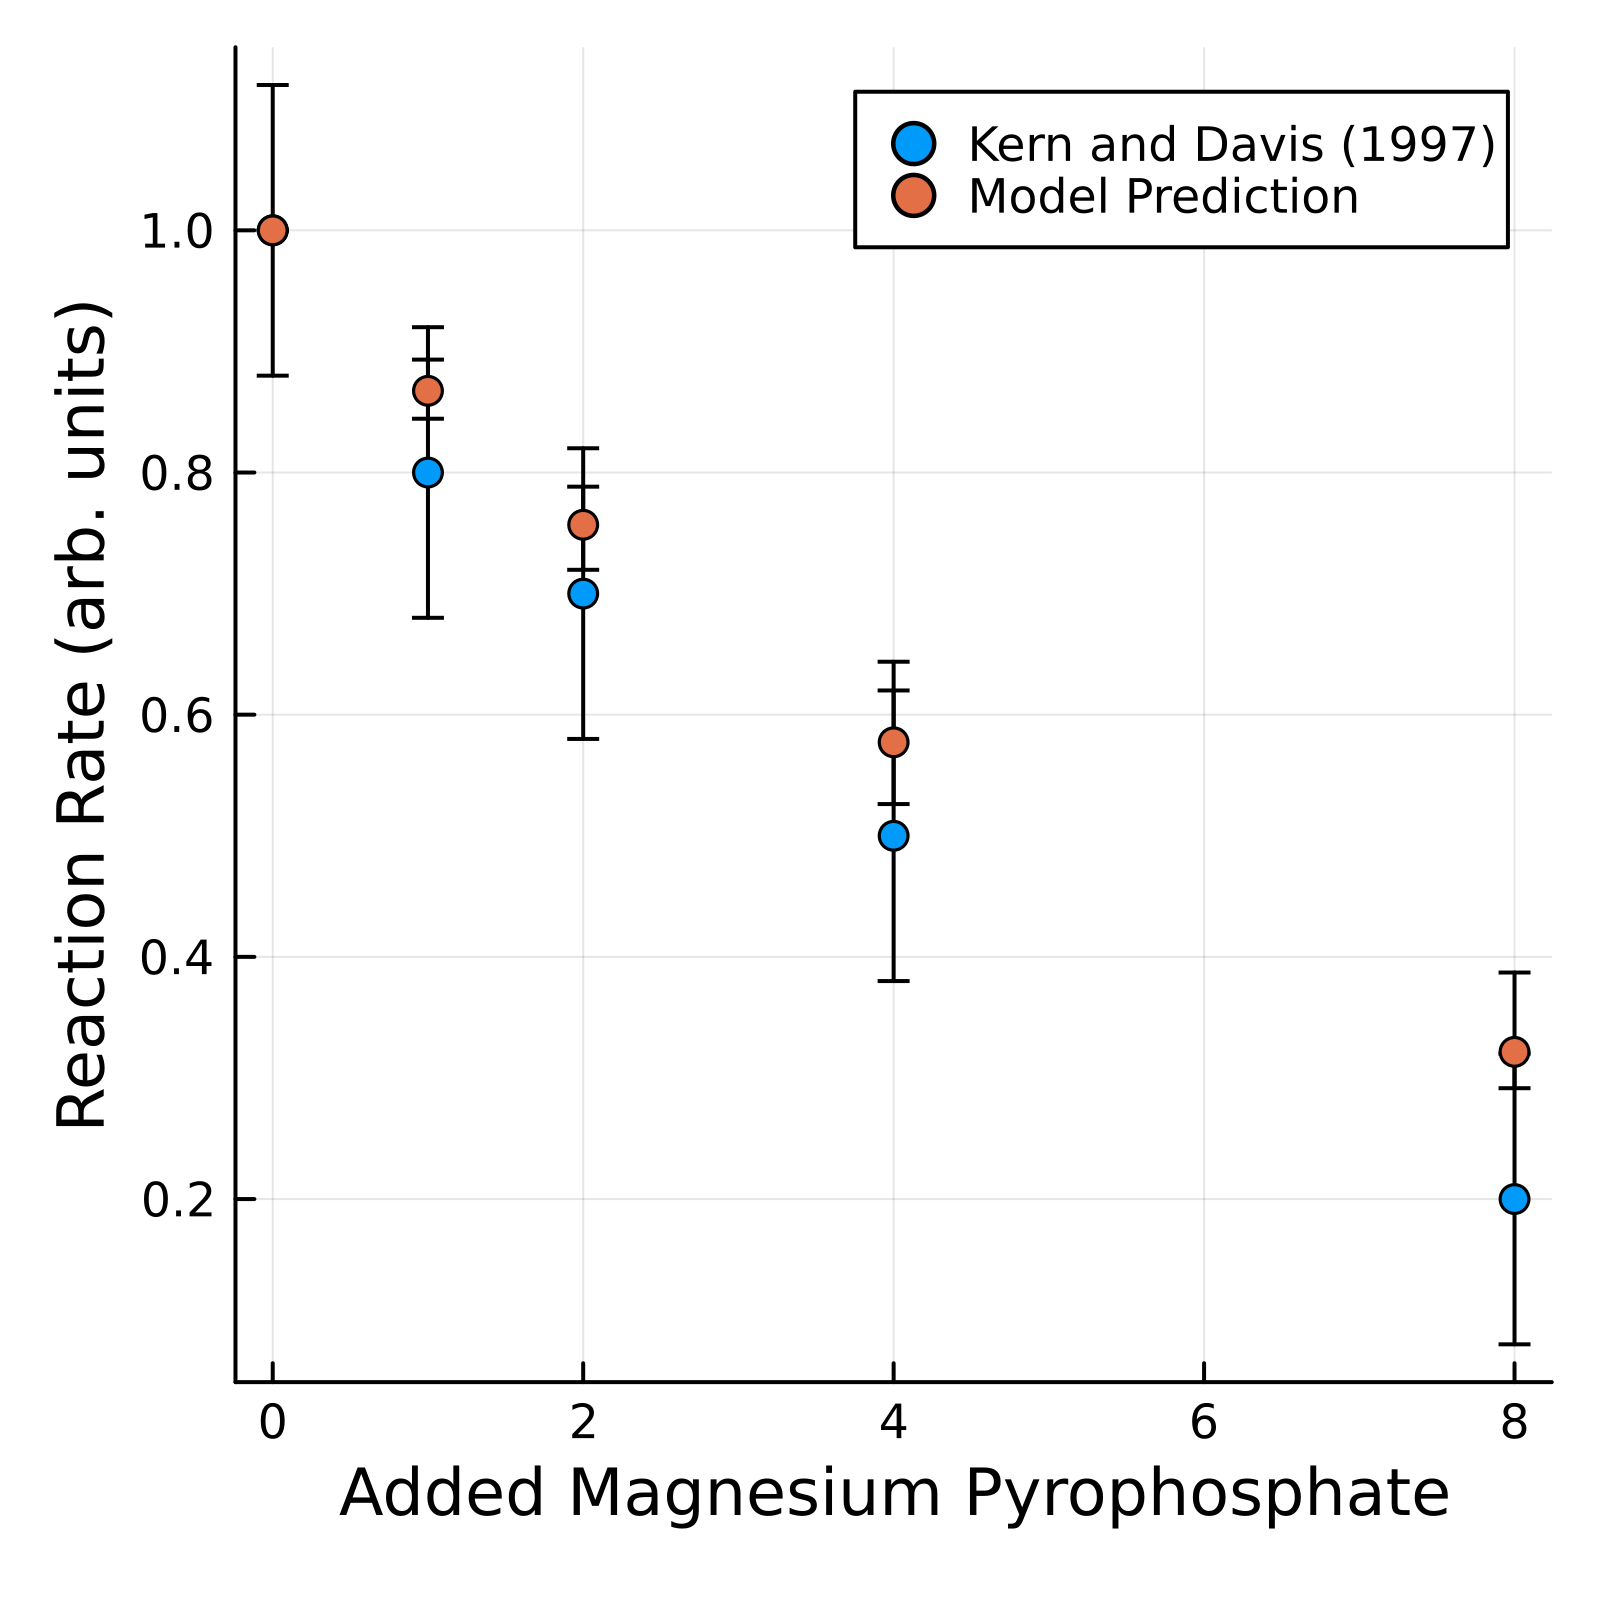

In [23]:
function getKernPPirate(param, NaPPiadded, MgOACadded, NaOACadded)
    UTPtot = 2e-3
    GTPtot = 2e-3
    CTPtot = 1.3e-3
    Mgtot = MgOACadded/1000
    Buffertot = 0.04

    T7 = 0.12e-6
    DNA = 90
    PPiase = 0.0
    stoich = (0,1.65,3.25,5)
    inputs =(T7RNAP = T7, ATP = 1e-9,UTP = UTPtot,CTP = CTPtot,GTP = GTPtot, Mg = Mgtot, Buffer = Buffertot, DNA = DNA, final_time = 0.01)
    sol = runDAE_batch(param,inputs, PPiase = PPiase, stoich = stoich, OAccounterion = true, Naanion = NaOACadded/1000, Na4PPi = NaPPiadded/1000)
    return totalrna(sol,0)[end]
end
PPinmc = 100
relativeKernPPi(param, NaPPiadded, MgOACadded, NaOACadded) = getKernPPirate(param, NaPPiadded, MgOACadded, NaOACadded)/getKernPPirate(param, 0.0, MgOACadded, NaOACadded)

kernPPiadded = [0,1,2,4,8]
kernMgadded = [11.3,12.75,14.22,17.2,23.1]
kernNaOAcadded = [86.9,82.4,77.9,69.0,51.1]
kernPPirate = [1.0,0.8,0.7,0.5,0.2]

kernpredictions = [relativeKernPPi(fittedparams, kernPPiadded[i], kernMgadded[i], kernNaOAcadded[i]) for i in 1:length(kernPPirate)]
kernpredictionCB = hcat([mcbounds(fittingmodel,fittedparamslist,covariancemat,p -> relativeKernPPi(p, kernPPiadded[i], kernMgadded[i], kernNaOAcadded[i]),nmc = PPinmc) for i in 1:length(kernPPirate)]...)
plt = scatter(kernPPiadded,kernPPirate,label = "Kern and Davis (1997)",yerror = 0.12)
scatter!(kernPPiadded,kernpredictions,label = "Model Prediction", xlabel = "Added Magnesium Pyrophosphate", size = (400,400),ylabel = "Reaction Rate (arb. units)",yerror = (kernpredictions .- kernpredictionCB[1,:],kernpredictionCB[2,:] .- kernpredictions))
plot!(dpi = 400)
savefig(plt,"../figures/GM6_27/samnuanPPi.png")
plt

┌ Warning: scale log is unsupported with Plots.GRBackend().
│ Choose from: [:identity, :ln, :log10, :log2]
└ @ Plots C:\Users\ChemeGrad2021\.julia\packages\Plots\sxUvK\src\args.jl:1584


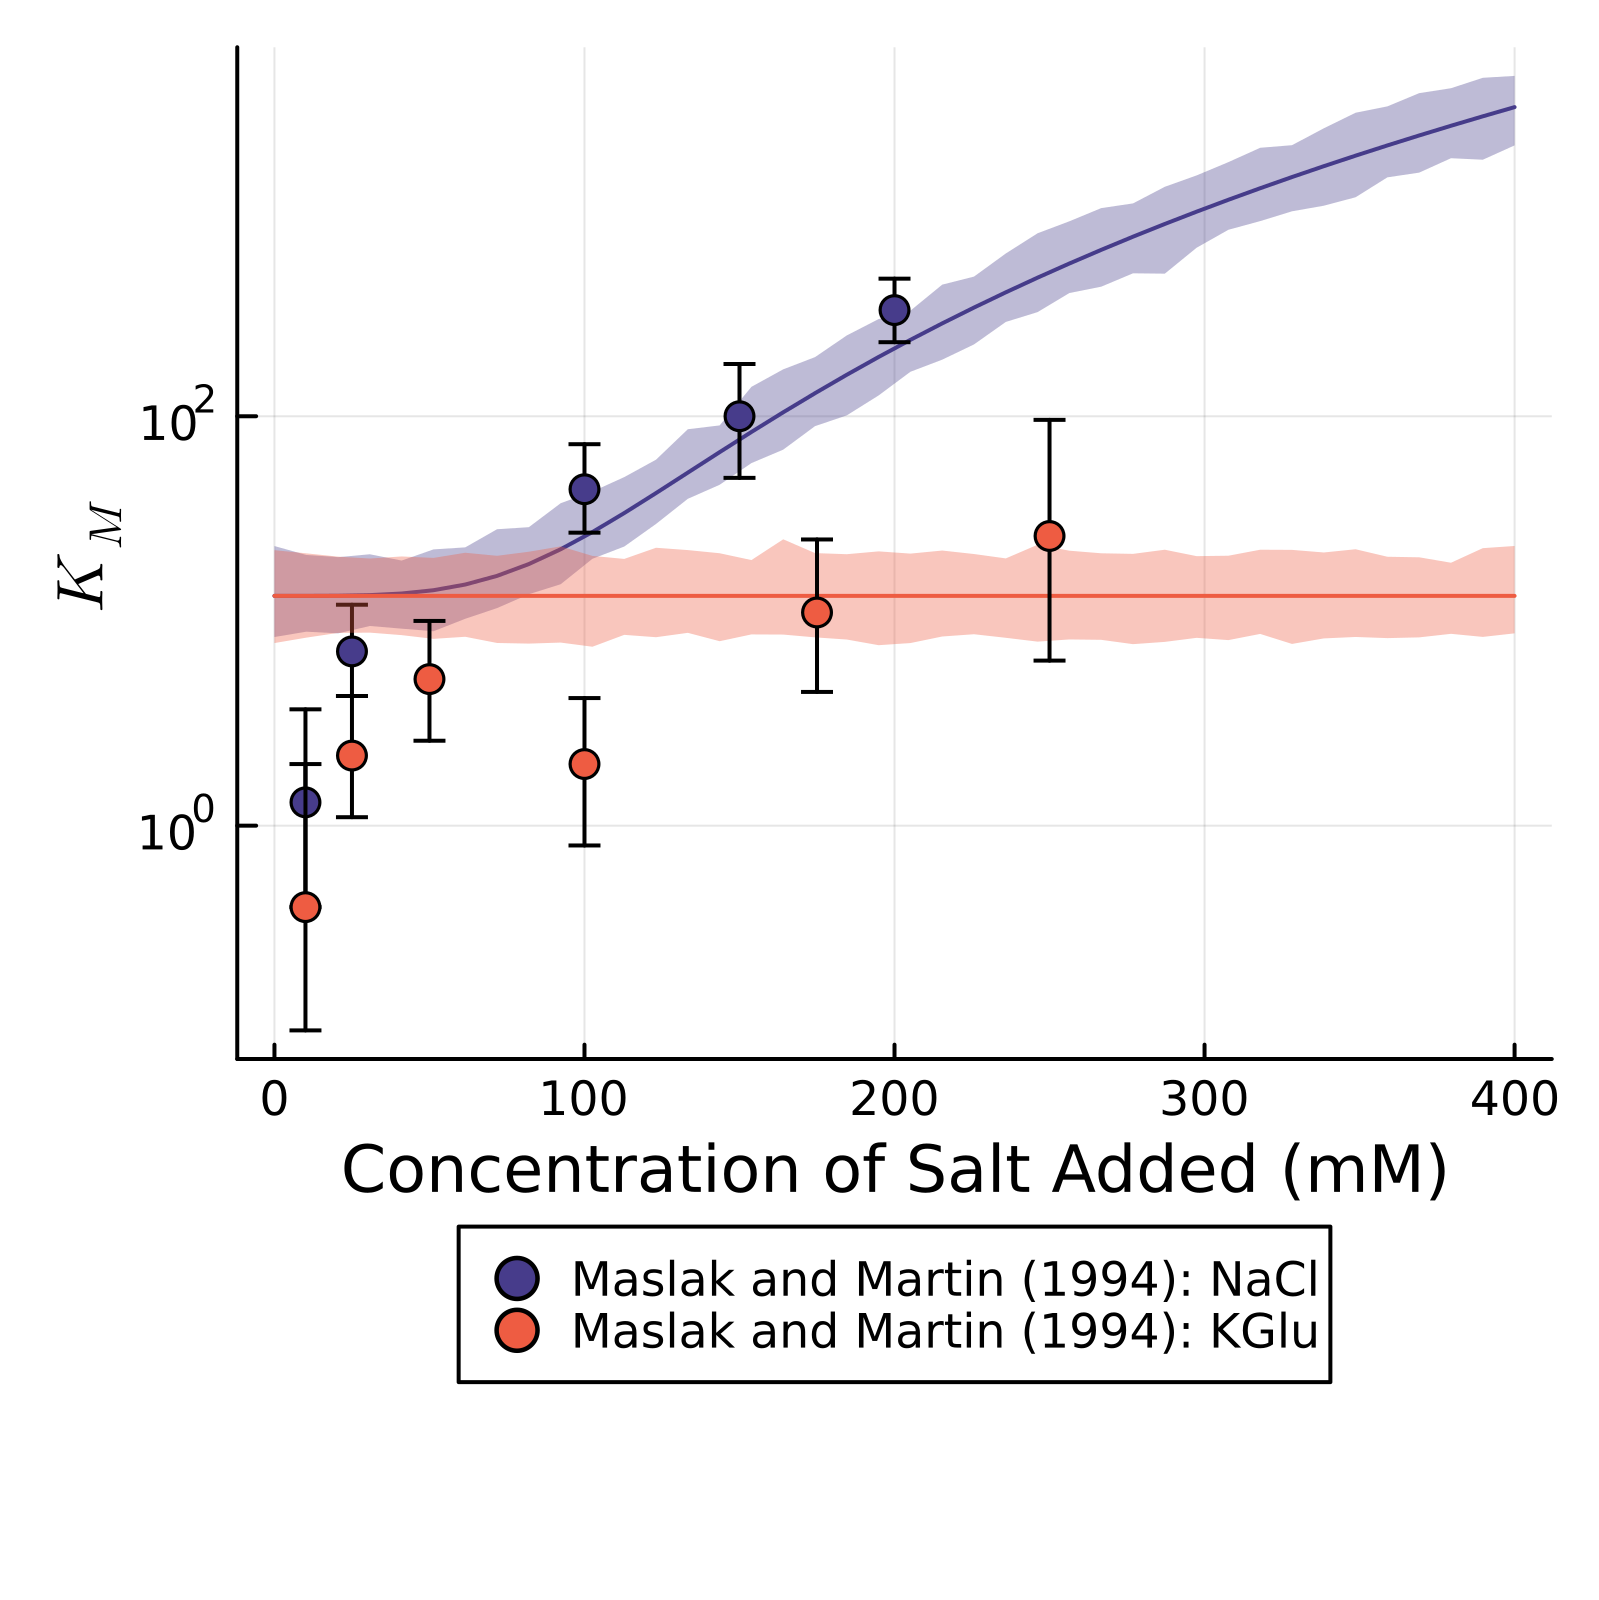

In [24]:
function getMaslakKMD(param,NaCl; K = 0)
    Cl = NaCl/1000
    Mg = 15e-3
    Nu = 4
    Nf = 4
    K_MD = (((1+(Cl*param.K_u0)^4)*(1+(Mg*param.K_Mg)^4))*param.k_off+param.k_i)/(param.k_on)
end
plottingnmc = 100
NaClrange = LinRange(0,400,40)

maslakNaCl = [10,25,100,150,200]
maslakNaClKMD = [1.3,7.1,44,100,330]
maslakuncertaintyNaCllow = [0.9,2.8,17,50,100]
maslakuncertaintyNaClhigh = [2.4,4.9,29,80,140]

predictedKMDNaCl = [getMaslakKMD(fittedparams,NaCl) for NaCl in NaClrange]
KMDNaCl_CB = hcat([mcbounds(fittingmodel,fittedparamslist,covariancemat,x->getMaslakKMD(x,NaCl),nmc = plottingnmc) for NaCl in NaClrange]...)
plt = plot(NaClrange,predictedKMDNaCl,yscale = :log, color = :slateblue4, label = "", ylabel = L"K_{M}", xlabel = "Concentration of Salt Added (mM)", legend = :outerright)
plot!(NaClrange, KMDNaCl_CB[1,:], fillrange = KMDNaCl_CB[2,:], fillalpha = 0.35,alpha=0.0, color = :slateblue4,linewidth = 0.0,label="")
scatter!(maslakNaCl,maslakNaClKMD, yerror = (maslakuncertaintyNaCllow, maslakuncertaintyNaClhigh), color = :slateblue4, label = "Maslak and Martin (1994): NaCl")

maslakKGlu = [10,25,50,100,175,250]
maslakKGluKMD = [0.4,2.2,5.2,2.0,11,26]
maslakuncertaintyKGlulow = [0.3,1.1,2.6,1.2,6.5,19.6]
maslakuncertaintyKGluhigh = [1.6,2.1,4.8,2.2,14,70]
predictedKMDKGlu = [getMaslakKMD(fittedparams,0,K = KGlu) for KGlu in NaClrange]
KMDKGlu_CB = hcat([mcbounds(fittingmodel,fittedparamslist,covariancemat,x->getMaslakKMD(x,0,K = KGlu),nmc = plottingnmc) for KGlu in NaClrange]...)

plot!(NaClrange,predictedKMDKGlu, color = :tomato2, label = "")
plot!(NaClrange, KMDKGlu_CB[1,:], fillrange = KMDKGlu_CB[2,:], fillalpha = 0.35,alpha=0.0, color = :tomato2,linewidth = 0.0,label="")
scatter!(maslakKGlu,maslakKGluKMD, yerror = (maslakuncertaintyKGlulow, maslakuncertaintyKGluhigh), color = :tomato2, label = "Maslak and Martin (1994): KGlu",size = (400,400), legend = :outerbottom)
plot!(dpi = 400)
savefig(plt,"../figures/GM6_27/maslakKMD.png")
plt

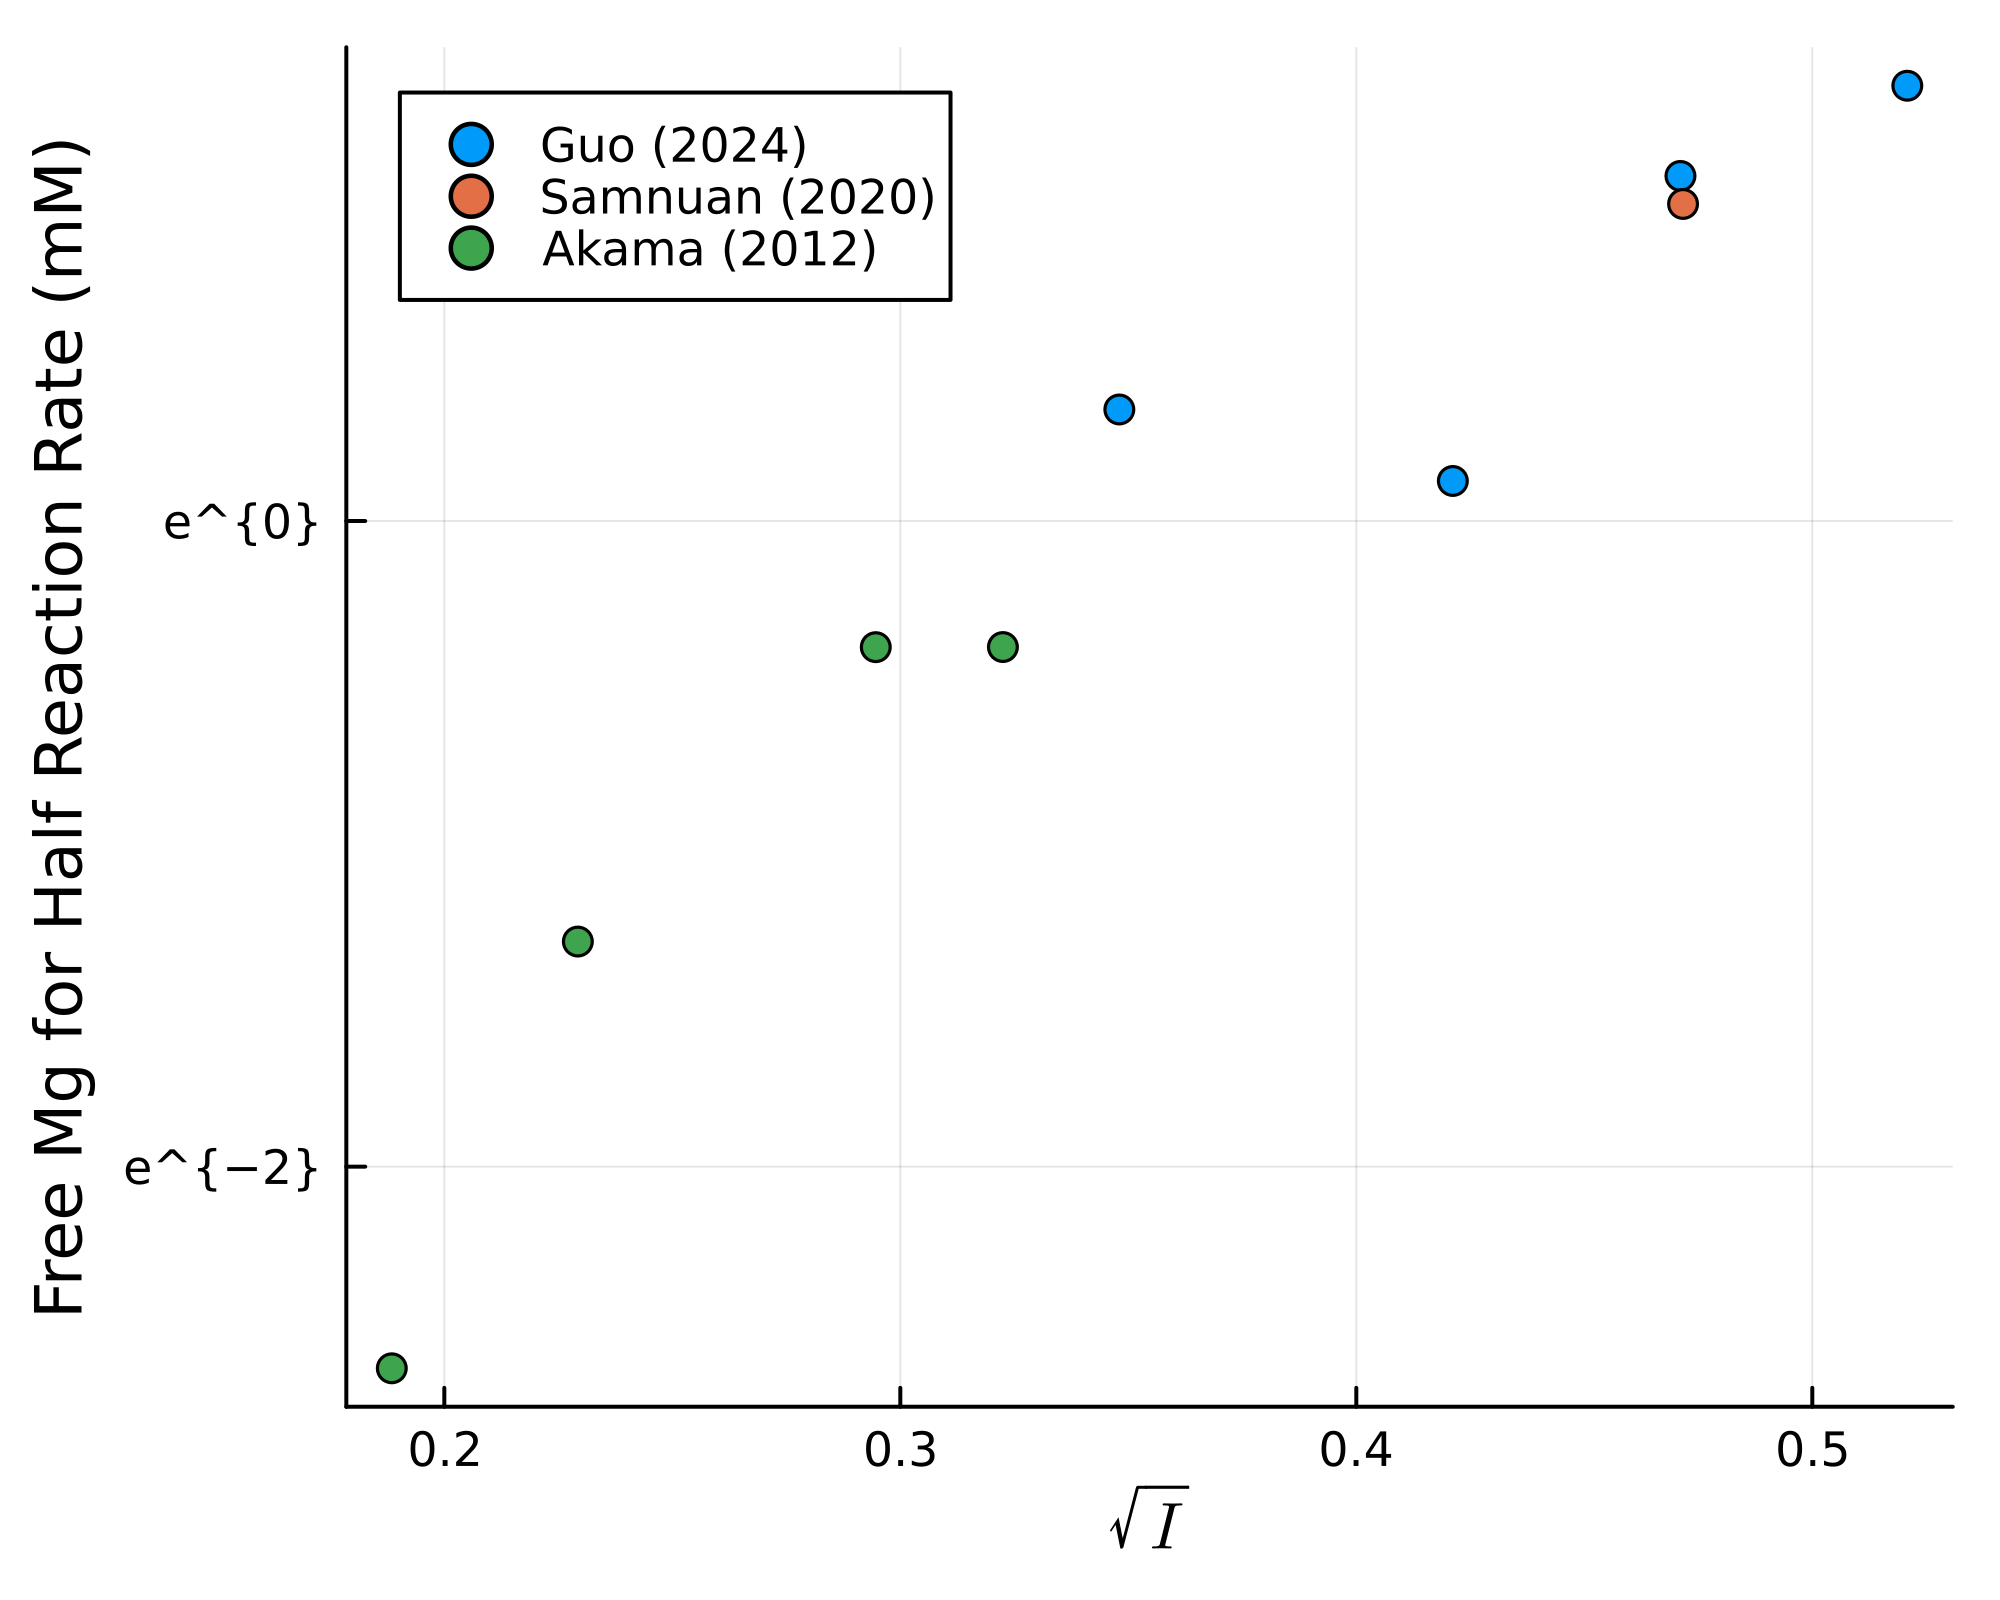

In [25]:
function getIS(param,NTPtot,Mgtot)
        NTPtot = NTPtot/1000
        Mgtot = Mgtot/1000
        Buffertot = 0.04
        Natot = 1e-8+Buffertot*((10^(-0.45))/(10^(-0.45)+1))+3.9*NTPtot
        PPitot = 1e-8
        Pitot = 1e-8
        Cltot = Mgtot*2
        (H, Mg, Na) = getfreeconcentrations(param, NTPtot, Mgtot, Buffertot, PPitot, Pitot, Natot, Cltot, 1e-9;buffer_pka = 7.48)
        return speciationmodel(param, 0, NTPtot, Mgtot, Buffertot, PPitot, Pitot, Natot, H, Mg, Na, Cltot, 1e-9)[1][6]
        #return getfreeconcentrations(param, NTPtot, Mgtot, Buffertot, PPitot, Pitot, Natot, Cltot;buffer_pka = 7.48)
end

function getfreeMg(param,NTPtot,Mgtot)
        NTPtot = NTPtot/1000
        Mgtot = Mgtot/1000
        Buffertot = 0.04
        Natot = 1e-8+Buffertot*((10^(-0.45))/(10^(-0.45)+1))+3.9*NTPtot
        PPitot = 1e-8
        Pitot = 1e-8
        Cltot = Mgtot*2
        (H, Mg, Na) = getfreeconcentrations(param, NTPtot, Mgtot, Buffertot, PPitot, Pitot, Natot, Cltot, 1e-9;buffer_pka = 7.48)
        return 1e3*Mg
        #return getfreeconcentrations(param, NTPtot, Mgtot, Buffertot, PPitot, Pitot, Natot, Cltot;buffer_pka = 7.48)
end

guoNTP = [20,30,40,50]
guoMgh = [19,25,42,55]
akamaNTP = [3.2,6.4,13,16]
akamaMgh = [1,4,10.5,12.5]
#kartjeNTP = [10,20,30]
#kartjeMgh = [12,23,36]
samnuanNTP = [40]
samnuanMgh = [41]

guoIS = [getIS(fittedparams,guoNTP[i],guoMgh[i]) for i in 1:4]
guofreeMg = [getfreeMg(fittedparams,guoNTP[i],guoMgh[i]) for i in 1:4]
akamaIS = [getIS(fittedparams,akamaNTP[i],akamaMgh[i]) for i in 1:4]
akamafreeMg = [getfreeMg(fittedparams,akamaNTP[i],akamaMgh[i]) for i in 1:4]
samnuanIS = [getIS(fittedparams,samnuanNTP[i],samnuanMgh[i]) for i in 1:1]
samnuanfreeMg = [getfreeMg(fittedparams,samnuanNTP[i],samnuanMgh[i]) for i in 1:1]
plt = scatter(sqrt.(guoIS),guofreeMg, label = "Guo (2024)")
scatter!(sqrt.(samnuanIS),samnuanfreeMg, label = "Samnuan (2020)")
scatter!(sqrt.(akamaIS),akamafreeMg, yscale = :ln, ylabel = "Free Mg for Half Reaction Rate (mM)", xlabel = L"\sqrt{I}", label = "Akama (2012)",size = (500,400))
plot!(dpi = 400)
savefig(plt,"../figures/GM6_27/masterhalf.png")
plt